In [1]:
from peak_warming_calculator  import *
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rc('font', family='serif')

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from numpy import genfromtxt
import matplotlib.cm as cm

In [4]:
import time

In [5]:
from SCC_functions import create_years_array

## 2016 figure using Nordhaus Damage function

In [6]:
# Define the model inputs
problem_2 = {
'num_vars': 2,
'names': ['P_50/P_100', 'P_100'],
'bounds': [[0.3, 0.75],
[200, 500]]
}
# Generate samples
param_values_2 = saltelli.sample(problem_2, 16)

In [7]:
# param_values_2

In [8]:
P_100_list = []

for i in range(len(param_values_2)):
    P_100_list.append(param_values_2[i][1])

In [9]:
consumption_growth_array = np.linspace(0.01, 0.035, 6)

T_list = []
output_list = []


T_TCRE = 0.00045  # degrees Celsius per GtCO2
r_minus_g = 0.015  # 1.5%

for j in range(len(consumption_growth_array)):
    peak_T_list = []
    output_data_list = []
    
    consumption_growth = consumption_growth_array[j]
    consumption_discount = consumption_growth + r_minus_g

    for i in range(len(param_values_2)):
        P_50 = param_values_2[i][0]*param_values_2[i][1]
        P_100 = param_values_2[i][1]
        r = consumption_discount
        s = r * 3
        peak_T, output_data = peak_warming_calculator(P_50=P_50, P_100=P_100, consumption_growth=consumption_growth, consumption_discount=consumption_discount, s=s, r=r, return_all_output=True, T_TCRE_1=T_TCRE)
        peak_T_list.append(peak_T)
        output_data_list.append(output_data)
    
    output_list.append(output_data_list)
    T_list.append(peak_T_list)
    
    print(consumption_growth_array[j])

/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calculator/peak_warming_calculator.py:138: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


0.01
0.015
0.02
0.025
0.03
0.035


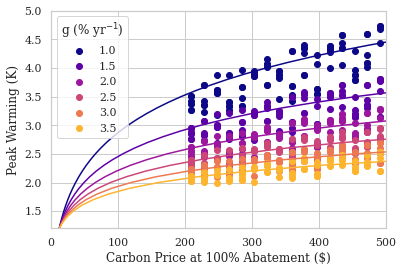

In [10]:
fig = plt.figure()

for i in range(len(T_list)):
    plt.scatter(P_100_list, T_list[i], color=cm.plasma(i/len(consumption_growth_array)), label=np.round(consumption_growth_array[i]*100, 3))
    
plt.legend(title="g (% yr$^{-1}$)")
plt.rc('font', family='serif')

## plot curves from Myles' paper
W0 = 80*10**12  
D0 = 0.00236


ks = 0.12  # per year
G = W0*D0*T_TCRE*(1/(r_minus_g)-1/(ks+r_minus_g))
gamma = 2
E_bar = 0.75*40
T_0 = 1.2

T_m = np.arange(T_0, 5,0.1)
g_bar = consumption_growth_array

for i in range(len(g_bar)):
    A_B = gamma*G*(T_m**(gamma-1))*np.exp((g_bar[i]/E_bar) * (T_m-T_0)/T_TCRE)
    plt.plot(A_B*10**(-9), T_m, color=cm.plasma(i/len(g_bar)))

plt.xlim(0, 500)
plt.ylim(1.2, 5)
plt.xlabel("Carbon Price at 100% Abatement ($)")
plt.ylabel("Peak Warming (K)")

fig.savefig('paper_figures/Nordhaus_runs_2016.png', bbox_inches='tight', dpi = 300)

In [11]:
start_year = 2020
end_year = 3000
years = create_years_array(start_year, end_year)

In [12]:
year_zero = []

for j in range(len(output_list)):
    
    year_zero_list = []

    for i in range(len(output_list[0])):
        for year in years:
            if output_list[j][i]['emissions'][year] == 0:
                year_zero_list.append(year)
                break
    year_zero.append(year_zero_list)

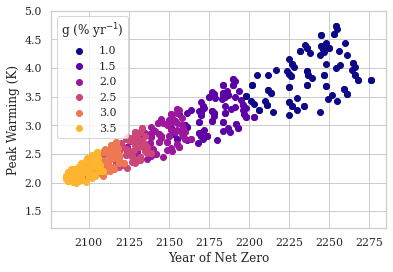

In [13]:
fig = plt.figure()

for i in range(len(year_zero)):
    plt.scatter(year_zero[i], T_list[i], color=cm.plasma(i/len(consumption_growth_array)), label=np.round(consumption_growth_array[i]*100, 3))

plt.ylim(1.2, 5)

plt.legend(title="g (% yr$^{-1}$)")
plt.rc('font', family='serif')

plt.xlabel("Year of Net Zero")
plt.ylabel("Peak Warming (K)")

fig.savefig('paper_figures/Nordhaus_runs_net_zero.png', bbox_inches='tight', dpi = 300)

In [14]:
SCC_2020 = []

for j in range(len(output_list)):
    
    SCC_2020_list = []

    for i in range(len(output_list[0])):
        SCC_2020_list.append(output_list[j][i]['SCC'].loc[2020])
    SCC_2020.append(SCC_2020_list)



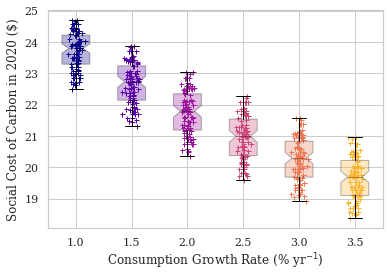

In [15]:
fig = plt.figure()

for i in range(len(consumption_growth_array)):
    consumption_growth = consumption_growth_array[i]
    
    y = SCC_2020[i]
    x = np.random.normal(consumption_growth*100, 0.03, len(y))
    plt.plot(x, y, ms=5, marker="+", linestyle="None", color=cm.plasma(i/len(SCC_2020)))

    plt.boxplot(y, positions=[np.round(consumption_growth*100, 3)], widths=0.25, notch=True, patch_artist=True, boxprops=dict(alpha=0.3, facecolor=cm.plasma(i/len(SCC_2020))), medianprops=dict(color="black", alpha=0.3))


plt.xlabel("Consumption Growth Rate (% yr$^{-1}$)")
plt.ylabel("Social Cost of Carbon in 2020 ($)")
plt.xlim(0.75, 3.75)

fig.savefig('paper_figures/Nordhaus_runs_SCC.png', bbox_inches='tight', dpi = 300)